In [ ]:
import torch
import os
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import cv2
import json
import torch.nn.functional as F
import math
import pprint
import requests
import numpy as np
from PIL import Image
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import defaultdict
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip /content/annotations_trainval2017.zip

--2023-11-26 13:08:22--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.7.189, 3.5.1.162, 52.216.152.220, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.7.189|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  55.3MB/s    in 4.8s    

2023-11-26 13:08:27 (49.9 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
train_ann = '/content/annotations/instances_train2017.json'
val_ann = '/content/annotations/instances_val2017.json'

!mkdir train
!mkdir validation

train_annotation = '/content/train/annotations/train2017.json'
val_annotation = '/content/validation/annotations/val2017.json'

train_images = '/content/train/images/'
val_images = '/content/validation/images/'

train_mask = '/content/train/masks/'
val_mask = '/content/validation/masks/'

In [ ]:
def getCocoDataset(annotation_path, image_path, object_class, limit=None):
  coco = COCO(annotation_path)

  catIds = coco.getCatIds(catNms=[object_class])
  imgIds = coco.getImgIds(catIds=catIds)
  images = coco.loadImgs(imgIds)

  os.makedirs(image_path, exist_ok=True)

  for i, im in enumerate(images):
    if i == limit:
      break
    img_data = requests.get(im['coco_url']).content
    with open(image_path + im['file_name'], 'wb') as handler:
        handler.write(img_data)
  return catIds

In [ ]:
class_id = getCocoDataset(train_ann, train_images, 'horse', 800)[0]
getCocoDataset(val_ann, val_images, 'horse', 200)

loading annotations into memory...
Done (t=26.26s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!


[19]

In [ ]:
def filterAnnotation(annotation_path, image_path, output_path):
  coco = COCO(annotation_path)

  images = os.listdir(image_path)

  os.makedirs('/'.join(output_path.split('/')[:-1]), exist_ok=True)

  filtered_annotations = {
    "images": [],
    "annotations": [],
    "categories": coco.dataset["categories"]
  }

  # Iterate through images and annotations
  for image_id in coco.getImgIds():
      image_info = coco.loadImgs([image_id])[0]
      if image_info['file_name'] in images:
          filtered_annotations["images"].append(image_info)
          annotations = coco.imgToAnns[image_id]
          filtered_annotations["annotations"].extend(annotations)

  # Save the filtered annotations to a new JSON file
  with open(output_path, 'w') as f:
      json.dump(filtered_annotations, f)


In [ ]:
filterAnnotation(train_ann, train_images, train_annotation)
filterAnnotation(val_ann, val_images, val_annotation)

loading annotations into memory...
Done (t=17.72s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


In [ ]:
def generate_segmentation_masks(annotation_path, class_id, output_dir):

    coco = COCO(annotation_path)

    os.makedirs(output_dir, exist_ok=True)

    img_ids = coco.getImgIds()

    min_height, min_width = math.inf, math.inf

    for img_id in img_ids:
        img_info = coco.loadImgs([img_id])[0]

        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)

        # Initialize a blank mask
        height = img_info['height']
        width = img_info['width']
        mask = np.zeros((height, width))


        # Generate the mask by drawing polygons for each annotation
        for annotation in annotations:

            if annotation['category_id'] != class_id:
              continue
            rle = maskUtils.frPyObjects(annotation['segmentation'],
                                        img_info['height'],
                                        img_info['width'])
            decoded_mask = maskUtils.decode(rle)
            if len(decoded_mask.shape) > 2:
              decoded_mask = decoded_mask[:, :, 0]
            mask += decoded_mask

        # Save the mask as an image
        mask_filename = os.path.join(output_dir,
                                     img_info['file_name'].replace('jpg', 'png'))
        cv2.imwrite(mask_filename, mask.astype(np.uint8) * 255)


In [ ]:
generate_segmentation_masks(train_annotation, class_id, train_mask)
generate_segmentation_masks(val_annotation, class_id, val_mask)

loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches**2, h * w * c // n_patches**2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                patch = image[
                    :,
                    i * patch_size : (i + 1) * patch_size,
                    j * patch_size : (j + 1) * patch_size,
                ]
                patches[idx, i * n_patches + j] = patch.flatten()
    return patches

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MultiHeadAttention, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.k_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.v_mappings = nn.ModuleList(
            [nn.Linear(d_head, d_head) for _ in range(self.n_heads)]
        )
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head : (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head**0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [ ]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = (
                np.sin(i / (10000 ** (j / d)))
                if j % 2 == 0
                else np.cos(i / (10000 ** ((j - 1) / d)))
            )
    return result

In [ ]:
class SegmentationHead(nn.Module):
    def __init__(self, in_dim):
        super(SegmentationHead, self).__init__()

        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_dim, 384, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(384, 192, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(192, 96, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, kernel_size=3, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(96, 48, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, kernel_size=3, padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        self.outconv = nn.Conv2d(48, 1, kernel_size=1)

    def forward(self, x):
        for conv in self.conv:
          x = conv(x)
        return self.outconv(x)

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(EncoderBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        self.norm1 = nn.LayerNorm(hidden_d)
        self.mhsa = MultiHeadAttention(hidden_d, n_heads)
        self.norm2 = nn.LayerNorm(hidden_d)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_ratio * hidden_d),
            nn.GELU(),
            nn.Linear(mlp_ratio * hidden_d, hidden_d),
        )

    def forward(self, x):
        out = x + self.mhsa(self.norm1(x))
        out = out + self.mlp(self.norm2(out))
        return out

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, chw=(3,256,256), n_patches=16, n_blocks=12, hidden_d=768, n_heads=12):
        # Super constructor
        super(VisionTransformer, self).__init__()

        # Attributes
        self.chw = chw  # ( C , H , W )
        self.n_patches = n_patches
        self.n_blocks = n_blocks
        self.n_heads = n_heads
        self.hidden_d = hidden_d

        # Input and patches sizes
        assert (
            chw[1] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        assert (
            chw[2] % n_patches == 0
        ), "Input shape not entirely divisible by number of patches"
        self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

        # 1) Linear mapper
        self.input_d = int(chw[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input_d, self.hidden_d)

        # 2) Learnable classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden_d))

        # 3) Positional embedding
        self.register_buffer(
            "positional_embeddings",
            get_positional_embeddings(n_patches**2 + 1, hidden_d),
            persistent=False,
        )

        # 4) Transformer encoder blocks
        self.blocks = nn.ModuleList(
            [EncoderBlock(hidden_d, n_heads) for _ in range(n_blocks)]
        )

        # 5) Skip connections
        self.skip_connections = nn.ModuleList([
            nn.Linear(hidden_d, hidden_d) for _ in range(n_blocks)
        ])

        # 6) Segmentation
        self.segmentation_head = SegmentationHead(hidden_d+3)

    def forward(self, images):
        # Dividing images into patches
        n, c, h, w = images.shape
        patches = patchify(images, self.n_patches).to(self.positional_embeddings.device)

        # Running linear layer tokenization
        # Map the vector corresponding to each patch to the hidden size dimension
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.cat((self.class_token.expand(n, 1, -1), tokens), dim=1)

        # Adding positional embedding
        out = tokens + self.positional_embeddings.repeat(n, 1, 1)

        # Transformer Blocks with skip connections
        # skip_connection_inputs = [out]
        for i, block in enumerate(self.blocks):
            out = block(out)
            # Add skip connection from the i-th block
            out += self.skip_connections[i](skip_connection_inputs[i])
            skip_connection_inputs.append(out)

        # Reshape and permute for segmentation head
        out_reshaped = out.view(n, self.n_patches, self.n_patches, -1).permute(0, 3, 1, 2)

        # Segmentation head
        segmentation_output = self.segmentation_head(out_reshaped)

        return segmentation_output

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('jpg', 'png'))


        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
# Hyperparameters
batch_size = 16
learning_rate = 1e-4
num_epochs = 10
num_classes = 2


# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [ ]:
train_dataset = CustomDataset('/content/train/images', '/content/train/masks', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CustomDataset('/content/validation/images', '/content/validation/masks', transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Initialize model, loss function, and optimizer
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = VisionTransformer().to(device)

In [ ]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

In [ ]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = nn.BCEWithLogitsLoss()(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

In [ ]:
def train_unet(model, train_loader, val_loader, num_epochs, learning_rate, device, save_path=None, patience=5):
    # criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
    metrics = defaultdict(float)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, verbose=True)


    best_val_loss = float('inf')
    best_model_state = None
    early_stopping_counter = 0

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1} (Train)"):
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # outputs = torch.sigmoid(outputs)
            # loss = criterion(outputs, masks)
            loss = calc_loss(outputs, masks, metrics)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, masks in tqdm(val_loader, desc=f"Epoch {epoch + 1} (Val)"):
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)
                # outputs = torch.sigmoid(outputs)
                # loss = criterion(outputs, masks)
                loss = calc_loss(outputs, masks, metrics)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            if save_path:
                torch.save(model.state_dict(), save_path)
            early_stopping_counter = 0  # Reset the counter
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping after {epoch + 1} epochs without improvement.")
            break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return model

In [ ]:
trained_model = train_unet(model, train_dataloader, val_dataloader, num_epochs, learning_rate, device, save_path='/content/best_model.pth', patience=3)

Epoch 1 (Val): 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


Epoch 1/10 - Train Loss: 0.6657 - Validation Loss: 0.6924


Epoch 2 (Val): 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


Epoch 2/10 - Train Loss: 0.6018 - Validation Loss: 0.6890


Epoch 3 (Val): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


Epoch 3/10 - Train Loss: 0.5784 - Validation Loss: 0.6084


Epoch 4 (Val): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Epoch 4/10 - Train Loss: 0.5620 - Validation Loss: 0.5762


Epoch 5 (Val): 100%|██████████| 8/8 [00:08<00:00,  1.06s/it]


Epoch 5/10 - Train Loss: 0.5483 - Validation Loss: 0.5521


Epoch 6 (Val): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


Epoch 6/10 - Train Loss: 0.5358 - Validation Loss: 0.5746


Epoch 7 (Val): 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]


Epoch 7/10 - Train Loss: 0.5240 - Validation Loss: 0.5170


Epoch 8 (Val): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


Epoch 8/10 - Train Loss: 0.5132 - Validation Loss: 0.5110


Epoch 9 (Val): 100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


Epoch 9/10 - Train Loss: 0.5034 - Validation Loss: 0.5469


Epoch 10 (Val): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


Epoch 10/10 - Train Loss: 0.4905 - Validation Loss: 0.5021


In [ ]:
!wget https://encrypted-tbn1.gstatic.com/licensed-image?q=tbn:ANd9GcSOD2yS2nqNxhV09Kk4fbOZw6sEuH1cxAZifXRS25GZccRScRYcJ9khSpuwW9uZmowN8qgc3zIL5_2PKb0 -O horse.jpg

--2023-11-26 13:43:04--  https://encrypted-tbn1.gstatic.com/licensed-image?q=tbn:ANd9GcSOD2yS2nqNxhV09Kk4fbOZw6sEuH1cxAZifXRS25GZccRScRYcJ9khSpuwW9uZmowN8qgc3zIL5_2PKb0
Resolving encrypted-tbn1.gstatic.com (encrypted-tbn1.gstatic.com)... 142.251.2.139, 142.251.2.102, 142.251.2.113, ...
Connecting to encrypted-tbn1.gstatic.com (encrypted-tbn1.gstatic.com)|142.251.2.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262790 (257K) [image/jpeg]
Saving to: ‘horse.jpg’

horse.jpg           100%[===================>] 256.63K  --.-KB/s    in 0.002s  

2023-11-26 13:43:04 (149 MB/s) - ‘horse.jpg’ saved [262790/262790]



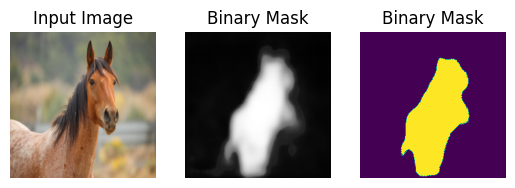

In [ ]:
model.eval()

original_image = Image.open('/content/horse.jpg')

original_image = transform(original_image).unsqueeze(0)

with torch.no_grad():
    predicted_mask_original = model(original_image.to('cuda'))

predicted_mask_sig = torch.sigmoid(predicted_mask_original)


plt.subplot(1, 3, 1)
plt.imshow(np.array(original_image.squeeze(0).permute(1, 2, 0)) )
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask_sig.cpu().numpy().squeeze(), cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

predicted_mask_sig[predicted_mask_sig>0.5] = 1
predicted_mask_sig[predicted_mask_sig<0.5] = 0

plt.subplot(1, 3, 3)
# plt.imshow(predicted_mask_sig.cpu().numpy().squeeze(), cmap='gray')
plt.imshow(predicted_mask_sig.cpu().numpy().squeeze())
plt.title('Binary Mask')
plt.axis('off')

plt.show()